In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"D:\$plouf\Formation DS\projet\dataset\tar\ascii\forms_clean.txt", sep=" ")

df.head()

,FormID,WriterID,NbSentences,WdSeg,Lines,OkSegLines,NbWords,OkNbWords
0,a01-000u,0,2,prt,7,5,52,36
1,a01-000x,1,2,all,6,6,52,52
2,a01-003,2,3,prt,11,10,81,71
3,a01-003u,0,3,prt,11,10,80,73
4,a01-003x,3,3,prt,9,6,82,56


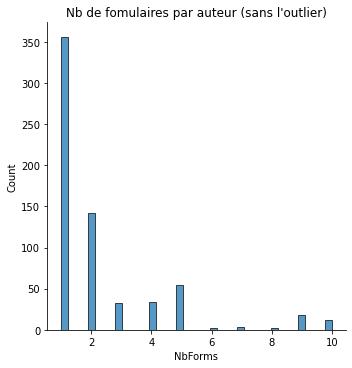

Nombre total :  657
Nombre de 3+ :  159
Nombre de 5+ :  93


In [76]:
#Nombre de formulaires remplis par personnne
nb_forms_pw = df[["FormID", "WriterID"]].groupby("WriterID").count()
nb_forms_pw.columns = ['NbForms']

# sns.relplot(x="WriterID", y="NbForms", data=nb_forms_pw)
sns.displot(x="NbForms", data=nb_forms_pw[nb_forms_pw['NbForms'] < 50])

plt.title("Nb de fomulaires par auteur (sans l'outlier)")
plt.show()

print('Nombre total : ', nb_forms_pw.shape[0])
print('Nombre de 3+ : ', nb_forms_pw[nb_forms_pw["NbForms"] >= 3].shape[0])
print('Nombre de 5+ : ', nb_forms_pw[nb_forms_pw["NbForms"] >= 5].shape[0])

### Ne pas prendre plus d'un formulaire par auteur lors de la découpe des sets training, validation et test ?


In [3]:
#Analyse des fichiers xml sur les forms
from lxml import etree

def get_words_from_form(filepath):
    words = []
    tree = etree.parse(filepath)
    for word in tree.xpath("/form/handwritten-part/line/word"):
        words.append(word.get('text'))
    return words

In [4]:
# parcours de tous les fichiers d'un dossier et ses sous-dossiers, possibilité de spécifier une extension et la recherche parmis les sous dossiers
import glob

def get_files(path, ext='', sub=False):
    if sub == True:
        path = path + '/**'     
    if ext != '':
        path = path + '/*.' + ext
    else:
        path = path + '/*.*'  # le . filtre les dossiers  
    files = glob.glob(path, recursive=sub)
    return files


all_files = get_files(r'D:\$plouf\Formation DS\projet\dataset\tar\xml', ext='xml', sub=True)
all_words = []
for file in all_files:
    all_words.extend(get_words_from_form(file))
all_letters = []
for word in all_words:
    all_letters.extend(list(word))
all_letters.sort()    

print('Nombre de forms chargés : ',len(all_files))
print('Nombre de mots chargés : ', len(all_words))
print('Nombre de lettres chargées : ', len(all_letters))


Nombre de forms chargés :  1539
Nombre de mots chargés :  115320
Nombre de lettres chargées :  475702


In [5]:
# creation d'un dataframe wavec tous les mots et leur longueur
df_words = pd.DataFrame(all_words, columns=['words'])
df_words['len'] = df_words['words'].apply(lambda w: len(w))

df_words.head(10)

,words,len
0,A,1
1,MOVE,4
2,to,2
3,stop,4
4,Mr.,3
5,Gaitskell,9
6,from,4
7,nominating,10
8,any,3
9,more,4


In [14]:
#détection des outliers : un mot "pourri" trouvé
# sns.displot(df_words['len'], kind = 'hist')
# plt.title('Nombre de lettres par mot')
print('Mot pourri : ', df_words['words'][df_words['len'] == 53])


Mot pourri :  107040    ----------------------------------------------...
Name: words, dtype: object


In [7]:
#suppression du "faux" mot pour meilleure visu
df_words2 = df_words.drop(index=107040)

Nombre de mots différents :  13549
Nombre de mots vues une seule fois :  7189
Nombre de mots vues 1000+ fois :  11


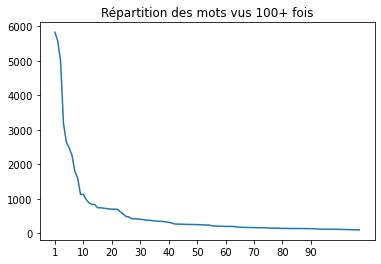

In [73]:
#Répartition des mots
from collections import Counter

df_words_count = pd.DataFrame(Counter(df_words2['words']).keys(), columns=['words'])
df_words_count['count'] = Counter(df_words2['words']).values()
df_words_count.sort_values(by='count', inplace=True, ascending=False)

print('Nombre de mots différents : ', len(df_words2['words'].unique()));
print('Nombre de mots vues une seule fois : ', len(df_words_count['count'][df_words_count['count'] == 1]));
print('Nombre de mots vues 1000+ fois : ', len(df_words_count['count'][df_words_count['count'] >= 1000]));

# df_words_count.head(20)
# ax = plt.gca()
# ax.axes.xaxis.set_visible(False)

plt.plot(df_words_count['words'][df_words_count['count'] > 100], df_words_count['count'][df_words_count['count'] > 100])
plt.xticks(np.arange(0, 100, 10), ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90'])
plt.title('Répartition des mots vus 100+ fois');

### beaucoup de mots ne sont vus qu'une seule fois, d'autres sont vus de très nombreuses fois, attention à l'overfitting

Nombre total de lettres :  475649
Nombre moyen de lettres par mot:  4.124636876837295


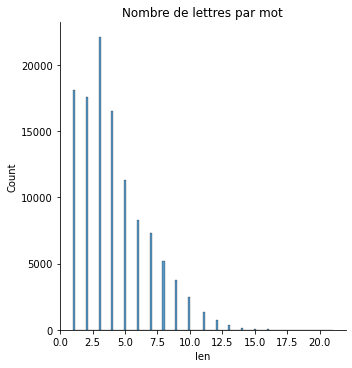

In [19]:
# Nombre de lettres par mot
sns.displot(df_words2['len'], kind = 'hist')
plt.title('Nombre de lettres par mot');

print('Nombre total de lettres : ', df_words2['len'].sum())
print('Nombre moyen de lettres par mot: ', df_words2['len'].mean())

Text(0.5, 1.0, 'Répartition de tous les caractères')

<Figure size 1080x2160 with 0 Axes>

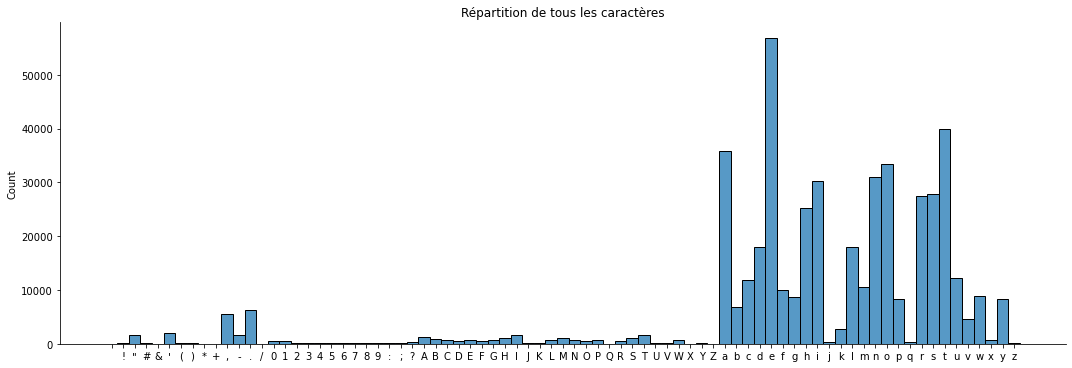

In [58]:
#répartition des lettres

plt.figure(figsize=(15,30))
sns.displot(all_letters, kind = 'hist', aspect=3)
plt.title('Répartition de tous les caractères')

Nombre total de lettres (pour verif): 475702


<Figure size 1440x1440 with 0 Axes>

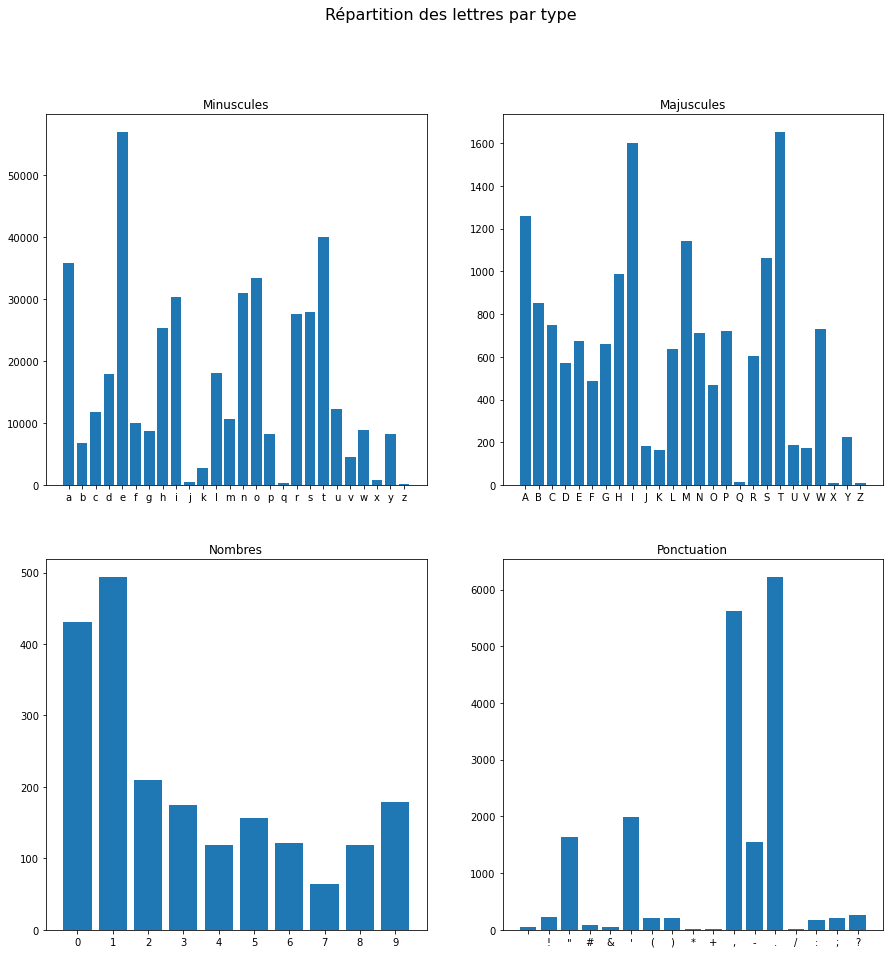

In [67]:
all_letters_low = [x for x in all_letters if x.islower()]
all_letters_up = [x for x in all_letters if x.isupper()]
all_letters_nbr = [x for x in all_letters if x.isdigit()]
all_letters_punc = [x for x in all_letters if (not x.islower()) and (not x.isupper()) and (not x.isdigit())]

print('Nombre total de lettres (pour verif):', len(all_letters_low)+len(all_letters_up)+len(all_letters_nbr)+len(all_letters_punc))

plt.figure(figsize= (20,20))

fig, axs = plt.subplots(2,2, figsize=(15,15))
fig.suptitle('Répartition des lettres par type', fontsize=16)
axs[0,0].bar(Counter(all_letters_low).keys(), Counter(all_letters_low).values());
axs[0,0].set_title('Minuscules')

axs[0,1].bar(Counter(all_letters_up).keys(), Counter(all_letters_up).values()); 
axs[0,1].set_title('Majuscules')

axs[1,0].bar(Counter(all_letters_nbr).keys(), Counter(all_letters_nbr).values());
axs[1,0].set_title('Nombres')

axs[1,1].bar(Counter(all_letters_punc).keys(), Counter(all_letters_punc).values());
axs[1,1].set_title('Ponctuation')

plt.show();

### bonne répartition des lettres par rapport à l'usage de celles-ci dans la langue 